# Evaluation of Dynamic Neural Networks 

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Input, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from keras.models import Model
import keras_tuner as kt
import keras.backend as K

from tensorflow.keras import initializers, regularizers

#### Configuring the fonts

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Functions

In [3]:
# Define the custom loss function for multi-step ahead prediction with exogenous variables
def multi_step_loss(y_true, y_pred):
    # Reshape y_true and y_pred to match the multi-step output shape
    y_true = K.reshape(y_true, (-1, 5*6))  # Adjust the shape to match the number of future steps
    y_pred = K.reshape(y_pred, (-1, 5*6))  # Adjust the shape to match the number of future steps

    # Calculate the mean squared error loss for each step
    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)

    # Return the average loss across all steps
    return K.mean(mse_loss)


## Data Preprocessing

### Reading the Data

In [4]:
path = 'Data/'

In [5]:
paths_train = [path + 'Tests0.txt_mean_11_39_02.txt',
               path + 'Tests1.txt_mean_08_33_39.txt',
               path + 'Tests1.txt_mean_11_15_31.txt',
               path + 'Tests2.txt_mean_08_26_59.txt'] 

paths_valid = [path + 'Tests_valid0.txt_mean_09_41_14.txt'] 
              
paths_test = [path + 'Tests_MPC0.txt_mean_12_38_39.txt'] 

In [6]:
X_train_1_raw = pd.read_csv(paths_train[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]
X_train_2_raw = pd.read_csv(paths_train[1], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]
X_train_3_raw = pd.read_csv(paths_train[2], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]
X_train_4_raw = pd.read_csv(paths_train[3], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]

y_train_1_raw = pd.read_csv(paths_train[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]
y_train_2_raw = pd.read_csv(paths_train[1], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]
y_train_3_raw = pd.read_csv(paths_train[2], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]
y_train_4_raw = pd.read_csv(paths_train[3], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]

X_valid_raw = pd.read_csv(paths_valid[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]
y_valid_raw = pd.read_csv(paths_valid[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]

X_test_raw = pd.read_csv(paths_test[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[0,38,2,3,4]]
y_test_raw = pd.read_csv(paths_test[0], skiprows = 6, sep = '\t', header=0, encoding='cp1252').iloc[:,[43]]


### Applying  a moving average 

In [8]:
# Rolling window
roll = 10

In [9]:
# Training Set
X_train_1_filtered = X_train_1_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
X_train_2_filtered = X_train_2_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
X_train_3_filtered = X_train_3_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
X_train_4_filtered = X_train_4_raw.rolling(roll, min_periods=1).mean().iloc[::roll]

y_train_1_filtered = y_train_1_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
y_train_2_filtered = y_train_2_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
y_train_3_filtered = y_train_3_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
y_train_4_filtered = y_train_4_raw.rolling(roll, min_periods=1).mean().iloc[::roll]

#Validation Set 
X_valid_filtered = X_valid_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
y_valid_filtered = y_valid_raw.rolling(roll, min_periods=1).mean().iloc[::roll]

#Test Set
X_test_filtered = X_test_raw.rolling(roll, min_periods=1).mean().iloc[::roll]
y_test_filtered = y_test_raw.rolling(roll, min_periods=1).mean().iloc[::roll]

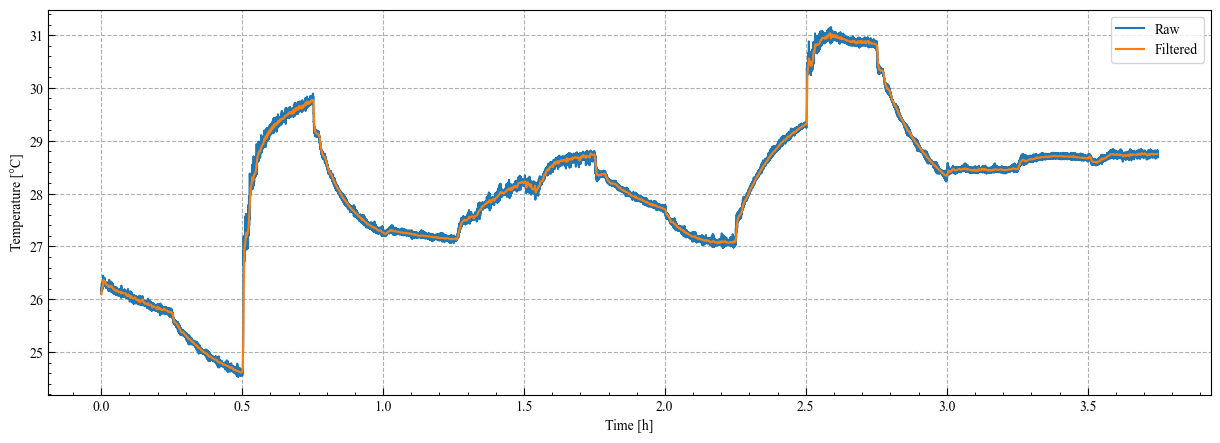

In [10]:
plt.figure(figsize = (15,5))

plt.plot(y_test_raw.index/60/60, y_test_raw, label = 'Raw')
plt.plot(y_test_filtered.index/60/60, y_test_filtered, label = 'Filtered')
plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Data_filter.pdf', dpi = 300, bbox_inches='tight')

### Determining exogenous events and inserting the utilization factor into the dataset

In [11]:
X_train_1_filtered['Start'] = 0
X_train_1_filtered.loc[0:10,'Start'] = 1

X_train_2_filtered['Start'] = 0
X_train_2_filtered.loc[0:10,'Start'] = 1

X_train_3_filtered['Start'] = 0
X_train_3_filtered.loc[0:10,'Start'] = 1

X_train_4_filtered['Start'] = 0
X_train_4_filtered.loc[0:10,'Start'] = 1

X_valid_filtered['Start'] = 0
X_valid_filtered.loc[0:10,'Start'] = 1

X_test_filtered['Start'] = 0
X_test_filtered.loc[0:10,'Start'] = 1

### Concatenating the training sets

In [12]:
X_train_exogenous = pd.concat((X_train_1_filtered, X_train_2_filtered, X_train_3_filtered, X_train_4_filtered,), ignore_index=True)
y_train_sequence = pd.concat((y_train_1_filtered, y_train_2_filtered, y_train_3_filtered, y_train_4_filtered), ignore_index=True)

### Converting the DataFrame to a numpy array

In [13]:
X_train_exogenous = X_train_exogenous.values
y_train_sequence = y_train_sequence.values

X_valid_exogenous = X_valid_filtered.values
y_valid_sequence = y_valid_filtered.values

X_test_exogenous = X_test_filtered.values
y_test_sequence = y_test_filtered.values

### Scalling the Data

In [14]:
scaler_exogenous = MinMaxScaler()
scaler_exogenous.fit(X_train_exogenous)
X_train_exogenous = scaler_exogenous.transform(X_train_exogenous)
X_valid_exogenous = scaler_exogenous.transform(X_valid_exogenous)
X_test_exogenous = scaler_exogenous.transform(X_test_exogenous)

In [15]:
scaller_endogenous = MinMaxScaler()
scaller_endogenous.fit(y_train_sequence)
y_train_sequence = scaller_endogenous.transform(y_train_sequence)
y_valid_sequence = scaller_endogenous.transform(y_valid_sequence)
y_test_sequence = scaller_endogenous.transform(y_test_sequence)

In [16]:
N_steps_back = int(5*60/roll)
N_steps_ahead = int(5*60/roll)

In [17]:
X_train_endogenous = []
y_train = []

for i in range(N_steps_back, len(y_train_sequence)-N_steps_ahead):
    X_train_endogenous.append(y_train_sequence[i-N_steps_back:i])
    y_train.append(y_train_sequence[i:i + N_steps_ahead])

X_train_endogenous, y_train = np.array(X_train_endogenous), np.array(y_train)

In [18]:
# Reshape X_train_endogenous to match the input shape of the RNN
X_train_endogenous = np.reshape(X_train_endogenous, (X_train_endogenous.shape[0], N_steps_back, 1))

# Reshape y_train to match the output shape of the RNN
y_train = np.reshape(y_train, (y_train.shape[0], N_steps_ahead))

In [19]:
X_valid_endogenous = []
y_valid = []

for i in range(N_steps_back, len(y_valid_sequence)-N_steps_ahead):
    X_valid_endogenous.append(y_valid_sequence[i-N_steps_back:i])
    y_valid.append(y_valid_sequence[i:i + N_steps_ahead])

X_valid_endogenous, y_valid = np.array(X_valid_endogenous), np.array(y_valid)

In [20]:
# Reshape X_valid_endogenous to match the input shape of the RNN
X_valid_endogenous = np.reshape(X_valid_endogenous, (X_valid_endogenous.shape[0], N_steps_back, 1))

# Reshape y_valid to match the output shape of the RNN
y_valid = np.reshape(y_valid, (y_valid.shape[0], N_steps_ahead))

In [21]:
X_test_endogenous = []
y_test = []

for i in range(N_steps_back, len(y_test_sequence)-N_steps_ahead):
    X_test_endogenous.append(y_test_sequence[i-N_steps_back:i].T)
    y_test.append(y_test_sequence[i:i + N_steps_ahead].T)

X_test_endogenous, y_test = np.array(X_test_endogenous), np.array(y_test)

In [22]:
# Reshape X_test_endogenous to match the input shape of the RNN
X_test_endogenous = np.reshape(X_test_endogenous, (X_test_endogenous.shape[0], N_steps_back, 1))

# Reshape y_test to match the output shape of the RNN
y_test = np.reshape(y_test, (y_test.shape[0], N_steps_ahead))

In [23]:
X_train_exogenous = X_train_exogenous[N_steps_back+N_steps_ahead:]
X_valid_exogenous = X_valid_exogenous[N_steps_back+N_steps_ahead:]
X_test_exogenous = X_test_exogenous[N_steps_back+N_steps_ahead:]

# Models

### Simple Recurrent Neural Network

### Building the Neural Network for Hyperparameter Optimization

In [24]:
def build_SRNN(hp):

    sequential_input = X_train_endogenous
    exogenous_input = X_train_exogenous

    # Define the dimensions of your input
    seq_input_dim = sequential_input.shape[2]
    exog_input_dim = exogenous_input.shape[1]

    # Glorot normal initializer
    initializer = tf.keras.initializers.GlorotNormal(seed = 42)

    inputs_endogenous = Input(shape=(None, seq_input_dim)) 
    inputs_exogenous = Input(shape=(exog_input_dim,)) 

    # Define the RNN layer
    RNN_units = hp.Int('rnn_units', 1, 25, step=3)
    RNN_output = SimpleRNN(units=RNN_units)(inputs_endogenous)
    
    # Define the batch normalization layer
    RNN_output = BatchNormalization()(RNN_output)

    # Define the dropout layer
    dropout_rate = hp.Choice('dropout_units_1', values = [0.0, 0.025, 0.05, 0.075, 0.1])
    RNN_output = Dropout(dropout_rate)(RNN_output)

    # Concatenate the RNN output and exogenous input
    exo = hp.Choice('exogenous_input', values = [True, False])
    if exo:
        concatenated_layers = concatenate([RNN_output, inputs_exogenous ])
    else:
        concatenated_layers = RNN_output

    # Define the dense layer
    dense_units = hp.Int('dense_units', 0, 50, step=5)
    dense_activation = hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    dense_output = Dense(units=dense_units, 
                         activation = dense_activation, 
                         kernel_initializer=initializer
                        #)(RNN_output)
                         )(concatenated_layers)

    # Define the batch normalization layer
    dense_output = BatchNormalization()(dense_output)

    # Define the dropout layer
    dropout_rate_2 = hp.Choice('dropout_units_2', values = [0.25, 0.3,0.35, 0.4])
    dense_output = Dropout(dropout_rate_2)(dense_output)

    # Define the output layer
    dense_activation_2 = hp.Choice('dense_activation_2', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    output = Dense(units=N_steps_ahead, 
                   activation = dense_activation_2, 
                   kernel_initializer=initializer
                   )(dense_output)
    
    # Define the model
    model = Model(inputs=[inputs_endogenous, inputs_exogenous], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
                                 weight_decay=hp.Choice('decay', values=[1e-1, 1e-2, 1e-3]),
                                ),
                  loss=multi_step_loss)
    return model

In [25]:
# Define the tuner
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        # Determining the Batch Size
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1*15, 3*15, step=3)
        # Determining the Number of Epochs
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 20, 70, step = 5)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [26]:
# Instantiate the tuner
tuner_SRNN = MyTuner(build_SRNN,
                objective = 'val_loss',
                directory= 'KT_Dir',
                project_name='SRNN',
                executions_per_trial = 1,   
)

INFO:tensorflow:Reloading Tuner from KT_Dir\SRNN\tuner0.json


In [27]:
# Search for the best hyperparameter configuration
tuner_SRNN.search([X_train_endogenous, X_train_exogenous], y_train,
                callbacks=[EarlyStopping('val_loss', patience=10)],
                verbose=1,
                validation_data=([X_valid_endogenous, X_valid_exogenous], y_valid)
                )

INFO:tensorflow:Oracle triggered exit


In [28]:
# Get the optimal model
model_SRNN = tuner_SRNN.get_best_models()[0]

In [30]:
# Get the optimal hyperparameters
best_hyp = tuner_SRNN.get_best_hyperparameters()[0]
print('\n The hyperparameters of the model are' + str(best_hyp.values) + '\n')

# Saving the Model
model_SRNN.save('Models/SRNN', include_optimizer=True)


 The hyperparameters of the model are{'rnn_units': 16, 'dropout_units_1': 0.0, 'exogenous_input': 0, 'dense_units': 10, 'dense_activation': 'softmax', 'dropout_units_2': 0.35, 'dense_activation_2': 'relu', 'learning_rate': 0.001, 'decay': 0.1, 'batch_size': 15, 'epochs': 25, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0241'}



INFO:tensorflow:Assets written to: Models/SRNN\assets


INFO:tensorflow:Assets written to: Models/SRNN\assets


In [30]:
model_SRNN = load_model('Models/SRNN', compile=True, custom_objects={'multi_step_loss': multi_step_loss})

### Performance

In [31]:
r2_train_SRNN = r2_score(y_train.flatten(), model_SRNN.predict([X_train_endogenous, X_train_exogenous]).flatten())
print("The Coefficient of Determination for the SRNN on the training set is " + str(r2_train_SRNN))
r2_valid_SRNN = r2_score(y_valid.flatten(), model_SRNN.predict([X_valid_endogenous, X_valid_exogenous]).flatten())
print("The Coefficient of Determination for the SRNN on the validation set is " + str(r2_valid_SRNN))
r2_test_SRNN = r2_score(y_test.flatten(), model_SRNN.predict([X_test_endogenous, X_test_exogenous]).flatten())
print("The Coefficient of Determination for the SRNN on the test set is " + str(r2_test_SRNN))

196/196 [==============================] - 1s 2ms/step
The Coefficient of Determination for the SRNN on the training set is 0.9456577003837185
25/25 [==============================] - 0s 2ms/step
The Coefficient of Determination for the SRNN on the validation set is 0.9763593649571988
41/41 [==============================] - 0s 2ms/step
The Coefficient of Determination for the SRNN on the test set is 0.8632861158537616


### Gated Recurrent Unit

### Building the Neural Network for Hyperparameter Optimization

In [32]:
def build_GRU(hp):

    sequential_input = X_train_endogenous
    exogenous_input = X_train_exogenous

    # Define the dimensions of your input
    seq_input_dim = sequential_input.shape[2]
    exog_input_dim = exogenous_input.shape[1]

    # Glorot normal initializer
    initializer = tf.keras.initializers.GlorotNormal(seed = 42)

    inputs_endogenous = Input(shape=(None, seq_input_dim)) 
    inputs_exogenous = Input(shape=(exog_input_dim,)) 

    # Define the RNN layer
    RNN_units = hp.Int('rnn_units', 1, 25, step=3)
    RNN_output = GRU(units=RNN_units)(inputs_endogenous)
    
    # Define the batch normalization layer
    RNN_output = BatchNormalization()(RNN_output)

    # Define the dropout layer
    dropout_rate = hp.Choice('dropout_units_1', values = [0.0, 0.025, 0.05, 0.075, 0.1])
    RNN_output = Dropout(dropout_rate)(RNN_output)

    # Concatenate the RNN output and exogenous input
    exo = hp.Choice('exogenous_input', values = [True, False])
    if exo:
        concatenated_layers = concatenate([RNN_output, inputs_exogenous ])
    else:
        concatenated_layers = RNN_output

    # Define the dense layer
    dense_units = hp.Int('dense_units', 0, 50, step=5)
    dense_activation = hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    dense_output = Dense(units=dense_units, 
                         activation = dense_activation, 
                         kernel_initializer=initializer
                        #)(RNN_output)
                         )(concatenated_layers)

    # Define the batch normalization layer
    dense_output = BatchNormalization()(dense_output)

    # Define the dropout layer
    dropout_rate_2 = hp.Choice('dropout_units_2', values = [0.25, 0.3,0.35, 0.4])
    dense_output = Dropout(dropout_rate_2)(dense_output)

    # Define the output layer
    dense_activation_2 = hp.Choice('dense_activation_2', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    output = Dense(units=N_steps_ahead, 
                   activation = dense_activation_2, 
                   kernel_initializer=initializer
                   )(dense_output)
    
    # Define the model
    model = Model(inputs=[inputs_endogenous, inputs_exogenous], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
                                 weight_decay=hp.Choice('decay', values=[1e-1, 1e-2, 1e-3]),
                                ),
                  loss=multi_step_loss)
    return model

In [33]:
# Define the tuner
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        # Determining the Batch Size
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 15, 45, step=3)
        # Determining the Number of Epochs
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 70, step = 5)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [34]:
# Instantiate the tuner
tuner_GRU = MyTuner(build_GRU,
                objective = 'val_loss',
                directory= 'KT_Dir',
                project_name='GRU',
                executions_per_trial = 1,   
)

INFO:tensorflow:Reloading Tuner from KT_Dir\GRU\tuner0.json


In [35]:
# Search for the best hyperparameter configuration
tuner_GRU.search([X_train_endogenous, X_train_exogenous], y_train,
                callbacks=[EarlyStopping('val_loss', patience=10)],
                verbose=1,
                validation_data=([X_valid_endogenous, X_valid_exogenous], y_valid)
                )

INFO:tensorflow:Oracle triggered exit


In [36]:
# Get the optimal model
model_GRU = tuner_GRU.get_best_models()[0]

In [37]:
# Get the optimal hyperparameters
best_hyp = tuner_GRU.get_best_hyperparameters()[0]
print('\n The hyperparameters of the model are' + str(best_hyp.values) + '\n')

# Saving the Model
#model_GRU.save('Models/GRU', include_optimizer=False)


 The hyperparameters of the model are{'rnn_units': 13, 'dropout_units_1': 0.075, 'exogenous_input': 0, 'dense_units': 50, 'dense_activation': 'tanh', 'dropout_units_2': 0.25, 'dense_activation_2': 'selu', 'learning_rate': 0.001, 'decay': 0.001, 'batch_size': 18, 'epochs': 55, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 4, 'tuner/round': 3, 'tuner/trial_id': '0136'}



In [38]:
model_GRU = load_model('Models/GRU', compile=True, custom_objects={'multi_step_loss': multi_step_loss})

### Performance

In [39]:
r2_train_GRU = r2_score(y_train.flatten(), model_GRU.predict([X_train_endogenous, X_train_exogenous]).flatten())
print("The Coefficient of Determination for the GRU on the training set is " + str(r2_train_GRU))
r2_valid_GRU = r2_score(y_valid.flatten(), model_GRU.predict([X_valid_endogenous, X_valid_exogenous]).flatten())
print("The Coefficient of Determination for the GRU on the validation set is " + str(r2_valid_GRU))
r2_test_GRU = r2_score(y_test.flatten(), model_GRU.predict([X_test_endogenous, X_test_exogenous]).flatten())
print("The Coefficient of Determination for the GRU on the test set is " + str(r2_test_GRU))

196/196 [==============================] - 1s 2ms/step
The Coefficient of Determination for the GRU on the training set is 0.9491241912967388
25/25 [==============================] - 0s 2ms/step
The Coefficient of Determination for the GRU on the validation set is 0.9774452657412561
41/41 [==============================] - 0s 2ms/step
The Coefficient of Determination for the GRU on the test set is 0.8905854542965964


### Long Short-Term Memory 

### Building the Neural Network for Hyperparameter Optimization

In [40]:
sequential_input = X_train_endogenous
exogenous_input = X_train_exogenous

In [41]:
def build_LSTM(hp):
        
    sequential_input = X_train_endogenous
    exogenous_input = X_train_exogenous

    # Define the dimensions of your input
    seq_input_dim = sequential_input.shape[2]
    exog_input_dim = exogenous_input.shape[1]

    # Glorot normal initializer
    initializer = tf.keras.initializers.GlorotNormal(seed = 42)

    inputs_endogenous = Input(shape=(None, seq_input_dim)) 
    inputs_exogenous = Input(shape=(exog_input_dim,)) 

    # Define the RNN layer
    RNN_units = hp.Int('rnn_units', 1, 25, step=3)
    RNN_output = LSTM(units=RNN_units)(inputs_endogenous)
    
    # Define the batch normalization layer
    RNN_output = BatchNormalization()(RNN_output)

    # Define the dropout layer
    dropout_rate = hp.Choice('dropout_units_1', values = [0.0, 0.025, 0.05, 0.075, 0.1])
    RNN_output = Dropout(dropout_rate)(RNN_output)

    # Concatenate the RNN output and exogenous input
    exo = hp.Choice('exogenous_input', values = [True, False])
    if exo:
        concatenated_layers = concatenate([RNN_output, inputs_exogenous ])
    else:
        concatenated_layers = RNN_output

    # Define the dense layer
    dense_units = hp.Int('dense_units', 0, 50, step=5)
    dense_activation = hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    dense_output = Dense(units=dense_units, 
                         activation = dense_activation, 
                         kernel_initializer=initializer
                        #)(RNN_output)
                         )(concatenated_layers)

    # Define the batch normalization layer
    dense_output = BatchNormalization()(dense_output)

    # Define the dropout layer
    dropout_rate_2 = hp.Choice('dropout_units_2', values = [0.25, 0.3,0.35, 0.4])
    dense_output = Dropout(dropout_rate_2)(dense_output)

    # Define the output layer
    dense_activation_2 = hp.Choice('dense_activation_2', values=['relu', 'sigmoid', 'tanh', 'selu', 'softmax'])
    output = Dense(units=N_steps_ahead, 
                   activation = dense_activation_2, 
                   kernel_initializer=initializer
                   )(dense_output)
    
    # Define the model
    model = Model(inputs=[inputs_endogenous, inputs_exogenous], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
                                 weight_decay=hp.Choice('decay', values=[1e-1, 1e-2, 1e-3]),
                                ),
                  loss=multi_step_loss)
    return model

In [42]:
# Define the tuner 
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        # Determining the Batch Size
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 15, 45, step=3)
        # Determining the Number of Epochs
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 20, 70, step = 5)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [43]:
# Instantiate the tuner
tuner_LSTM = MyTuner(build_LSTM,
                objective = 'val_loss',
                directory= 'KT_Dir',
                project_name='LSTM',
                executions_per_trial = 1,   
)

INFO:tensorflow:Reloading Tuner from KT_Dir\LSTM\tuner0.json


In [44]:
# Search for the best hyperparameter configuration
tuner_LSTM.search([X_train_endogenous, X_train_exogenous], y_train,
                callbacks=[EarlyStopping('val_loss', patience=10)],
                verbose=1,
                validation_data=([X_valid_endogenous, X_valid_exogenous], y_valid)
                )

INFO:tensorflow:Oracle triggered exit


In [45]:
# Get the optimal model
model_LSTM = tuner_LSTM.get_best_models()[0]

In [46]:
# Get the optimal hyperparameters
best_hyp = tuner_LSTM.get_best_hyperparameters()[0]
print('\n The hyperparameters of the model are' + str(best_hyp.values) + '\n')

# Saving the Model
#model_LSTM.save('Models/LSTM', include_optimizer=False)


 The hyperparameters of the model are{'rnn_units': 22, 'dropout_units_1': 0.075, 'exogenous_input': 0, 'dense_units': 35, 'dense_activation': 'selu', 'dropout_units_2': 0.3, 'dense_activation_2': 'sigmoid', 'learning_rate': 0.0001, 'decay': 0.001, 'batch_size': 15, 'epochs': 25, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0233'}



In [47]:
model_LSTM = load_model('Models/LSTM', compile=True, custom_objects={'multi_step_loss': multi_step_loss})

### Performance

In [48]:
r2_train_LSTM = r2_score(y_train.flatten(), model_LSTM.predict([X_train_endogenous, X_train_exogenous]).flatten())
print("The Coefficient of Determination for the LSTM on the training set is " + str(r2_train_LSTM))
r2_valid_LSTM = r2_score(y_valid.flatten(), model_LSTM.predict([X_valid_endogenous, X_valid_exogenous]).flatten())
print("The Coefficient of Determination for the LSTM on the validation set is " + str(r2_valid_LSTM))
r2_test_LSTM = r2_score(y_test.flatten(), model_LSTM.predict([X_test_endogenous, X_test_exogenous]).flatten())
print("The Coefficient of Determination for the LSTM on the test set is " + str(r2_test_LSTM))

196/196 [==============================] - 1s 3ms/step
The Coefficient of Determination for the LSTM on the training set is 0.9459530381730454
25/25 [==============================] - 0s 3ms/step
The Coefficient of Determination for the LSTM on the validation set is 0.9778060671110221
41/41 [==============================] - 0s 3ms/step
The Coefficient of Determination for the LSTM on the test set is 0.8757297435304586


## Plotting the results

### 1 step ahead prediction

196/196 [==============================] - 1s 3ms/step


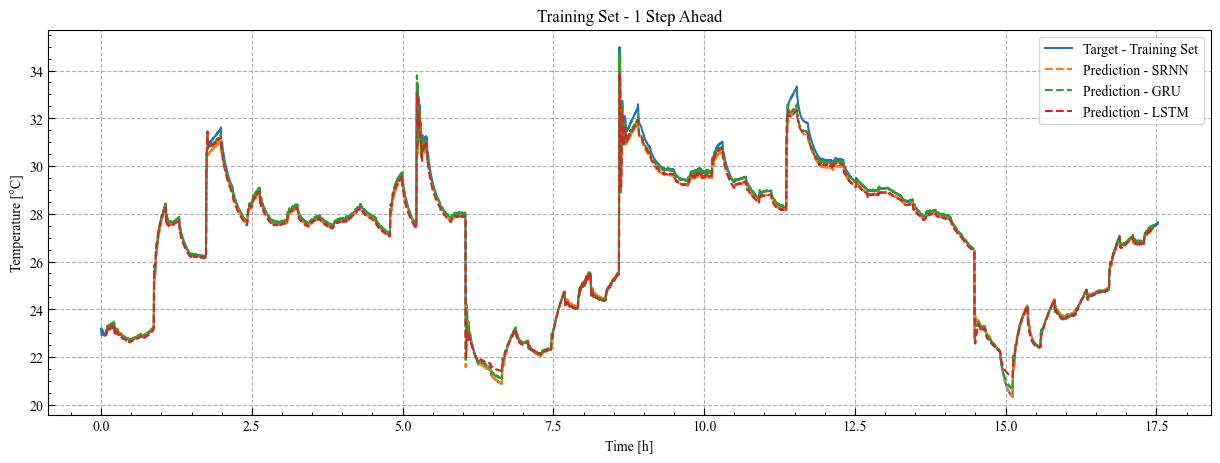

In [49]:
plt.figure(figsize=(15,5))

plt.plot(np.linspace(1,len(y_train_sequence),len(y_train_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_train_sequence), '-', label = 'Target - Training Set')
plt.plot(np.linspace(N_steps_back,len(y_train_sequence)-N_steps_ahead,len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_SRNN.predict([X_train_endogenous, X_train_exogenous]).T[0].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - SRNN')
plt.plot(np.linspace(N_steps_back,len(y_train_sequence)-N_steps_ahead,len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_GRU.predict([X_train_endogenous, X_train_exogenous]).T[0].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - GRU')
plt.plot(np.linspace(N_steps_back,len(y_train_sequence)-N_steps_ahead,len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_LSTM.predict([X_train_endogenous, X_train_exogenous]).T[0].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - LSTM')
plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Training Set - 1 Step Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Train_First.pdf', dpi = 300, bbox_inches='tight')

25/25 [==============================] - 0s 4ms/step


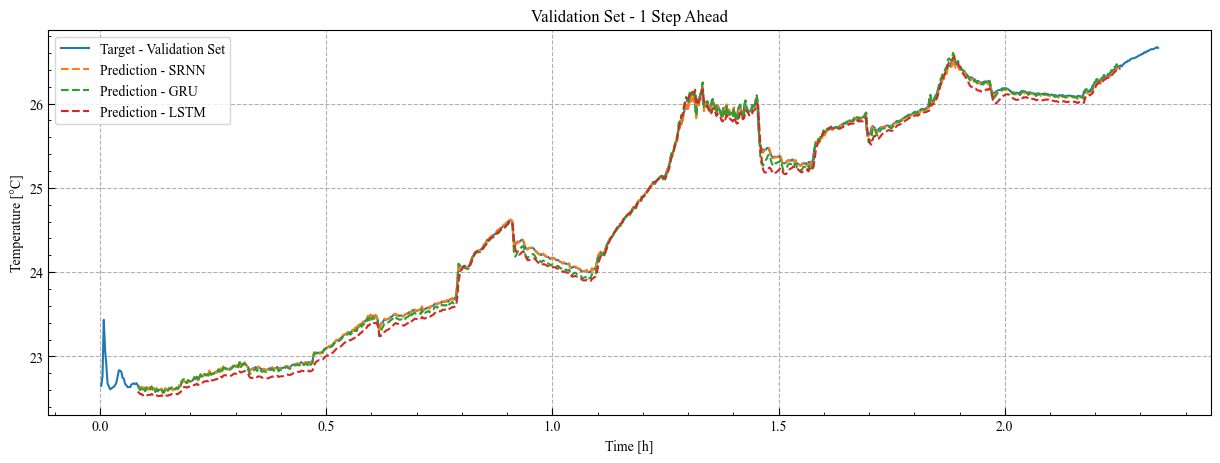

In [50]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,len(y_valid_sequence),len(y_valid_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_valid_sequence), '-', label = 'Target - Validation Set')
plt.plot(np.linspace(N_steps_back,len(y_valid_sequence) - N_steps_ahead,len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_SRNN.predict([X_valid_endogenous, X_valid_exogenous]).T[0].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - SRNN')
plt.plot(np.linspace(N_steps_back,len(y_valid_sequence) - N_steps_ahead,len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_GRU.predict([X_valid_endogenous, X_valid_exogenous]).T[0].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - GRU')
plt.plot(np.linspace(N_steps_back,len(y_valid_sequence) - N_steps_ahead,len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_LSTM.predict([X_valid_endogenous, X_valid_exogenous]).T[0].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction - LSTM')
plt.legend()
plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Validation Set - 1 Step Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Valid_First.pdf', dpi = 300, bbox_inches='tight')

41/41 [==============================] - 0s 3ms/step


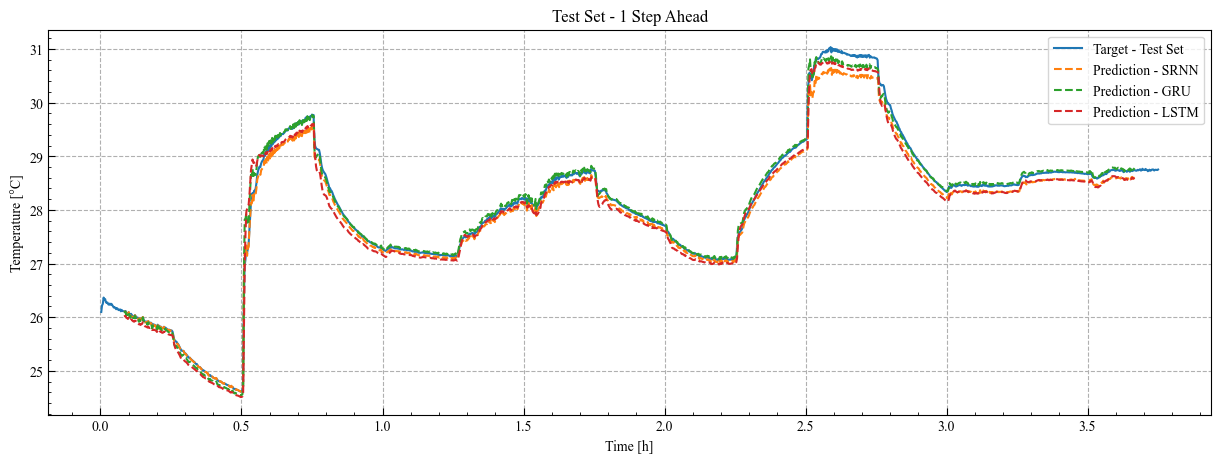

In [51]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,len(y_test_sequence),len(y_test_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_test_sequence), '-', label = 'Target - Test Set')
plt.plot(np.linspace(N_steps_back,len(y_test_sequence) - N_steps_ahead,len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_SRNN.predict([X_test_endogenous, X_test_exogenous]).T[0].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction - SRNN')
plt.plot(np.linspace(N_steps_back,len(y_test_sequence) - N_steps_ahead,len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_GRU.predict([X_test_endogenous, X_test_exogenous]).T[0].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction - GRU')
plt.plot(np.linspace(N_steps_back,len(y_test_sequence) - N_steps_ahead,len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_LSTM.predict([X_test_endogenous, X_test_exogenous]).T[0].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction - LSTM')
plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Test Set - 1 Step Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Test_First.pdf', dpi = 300, bbox_inches='tight')

### 5 steps ahead prediction

#### Auto-Regressive

In [59]:
def auto_regression(y, x_en, x_ex, model):
    T_N_steps_ahead = []
    for j in range(0,len(y)-2*N_steps_ahead-N_steps_back,6*5):
        X_endo = x_en[j].reshape(1, N_steps_back,1)

        for i in range(N_steps_ahead):
            X_exo = x_ex[j+i].reshape(1,6)
            next_step = model.predict([X_endo, X_exo], verbose = 0)
            X_endo = np.concatenate((X_endo[:, 1:, :], next_step[0][0].reshape(1,1,1)), axis=1)
        T_N_steps_ahead.append(next_step[0][0])
    return(T_N_steps_ahead)

In [ ]:
AutoG_train_SRNN = auto_regression(y_train_sequence, X_train_endogenous, X_train_exogenous, model_SRNN)
print('Done')
AutoG_valid_SRNN = auto_regression(y_valid_sequence, X_valid_endogenous, X_valid_exogenous, model_SRNN)
print('Done')
AutoG_test_SRNN = auto_regression(y_test_sequence, X_test_endogenous, X_test_exogenous, model_SRNN)

In [ ]:
AutoG_train_GRU = auto_regression(y_train_sequence, X_train_endogenous, X_train_exogenous, model_GRU)
print('Done')
AutoG_valid_GRU = auto_regression(y_valid_sequence, X_valid_endogenous, X_valid_exogenous, model_GRU)
print('Done')
AutoG_test_GRU = auto_regression(y_test_sequence, X_test_endogenous, X_test_exogenous, model_GRU)

In [ ]:
AutoG_train_LSTM = auto_regression(y_train_sequence, X_train_endogenous, X_train_exogenous, model_LSTM)
print('Done')
AutoG_valid_LSTM = auto_regression(y_valid_sequence, X_valid_endogenous, X_valid_exogenous, model_LSTM)
print('Done')
AutoG_test_LSTM = auto_regression(y_test_sequence, X_test_endogenous, X_test_exogenous, model_LSTM)

  1/196 [..............................] - ETA: 4s

196/196 [==============================] - 1s 3ms/step


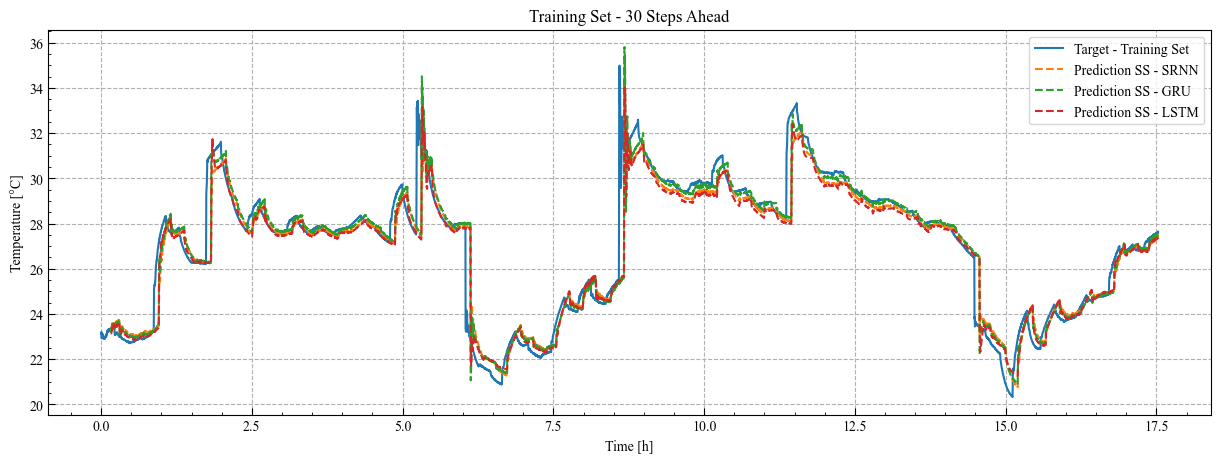

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(np.linspace(1,len(y_train_sequence),len(y_train_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_train_sequence), '-', label = 'Target - Training Set')
plt.plot(np.linspace(N_steps_back+ N_steps_ahead,len(y_train_sequence),len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_SRNN.predict([X_train_endogenous, X_train_exogenous]).T[-1].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - SRNN')
plt.plot(np.linspace(N_steps_back+ N_steps_ahead,len(y_train_sequence),len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_GRU.predict([X_train_endogenous, X_train_exogenous]).T[-1].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - GRU')
plt.plot(np.linspace(N_steps_back+ N_steps_ahead,len(y_train_sequence),len(y_train_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_LSTM.predict([X_train_endogenous, X_train_exogenous]).T[-1].reshape(y_train_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - LSTM')




plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Training Set - ' + str(N_steps_ahead) + ' Steps Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Train_Last_SS .pdf', dpi = 300, bbox_inches='tight')

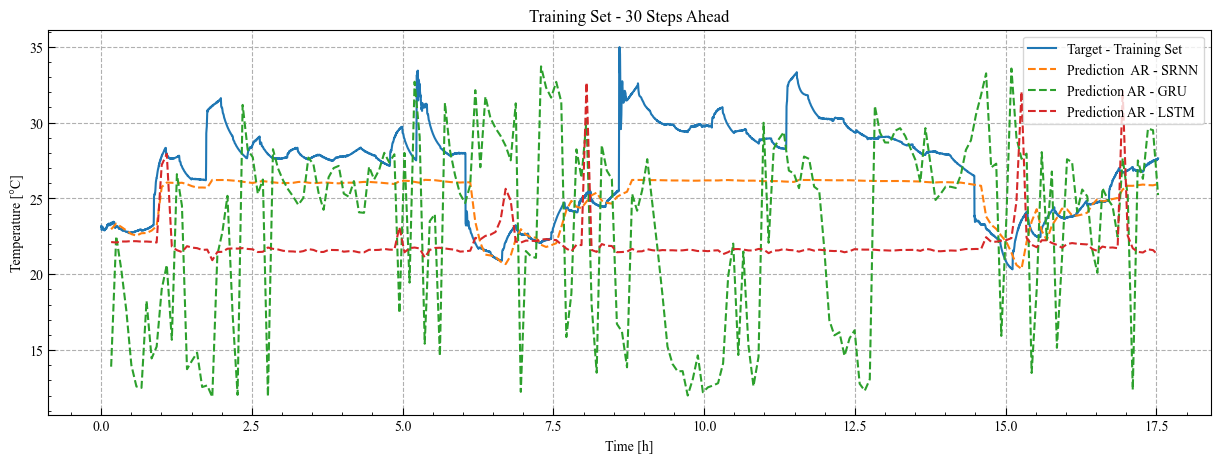

In [99]:
plt.figure(figsize=(15,5))

plt.plot(np.linspace(1,len(y_train_sequence),len(y_train_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_train_sequence), '-', label = 'Target - Training Set')

plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_train_sequence),int(np.ceil((len(y_train_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_train_SRNN).reshape(np.array(AutoG_train_SRNN).shape[0], 1)), '--', label = 'Prediction  AR - SRNN')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_train_sequence),int(np.ceil((len(y_train_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_train_GRU).reshape(np.array(AutoG_train_GRU).shape[0], 1)), '--', label = 'Prediction AR - GRU')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_train_sequence),int(np.ceil((len(y_train_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_train_LSTM).reshape(np.array(AutoG_train_LSTM).shape[0], 1)), '--', label = 'Prediction AR - LSTM')

plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Training Set - ' + str(N_steps_ahead) + ' Steps Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Train_Last_AR.pdf', dpi = 300, bbox_inches='tight')

 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 3ms/step


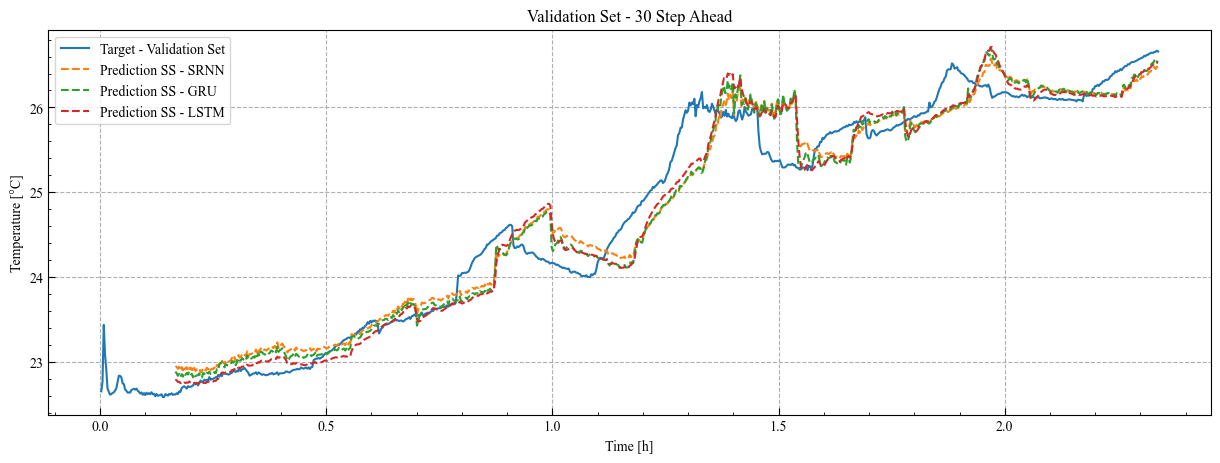

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,len(y_valid_sequence),len(y_valid_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_valid_sequence), '-', label = 'Target - Validation Set')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_valid_sequence),len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_SRNN.predict([X_valid_endogenous, X_valid_exogenous]).T[-1].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - SRNN')
plt.plot(np.linspace(N_steps_ahead + N_steps_back,len(y_valid_sequence),len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_GRU.predict([X_valid_endogenous, X_valid_exogenous]).T[-1].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - GRU')
plt.plot(np.linspace(N_steps_ahead + N_steps_back,len(y_valid_sequence),len(y_valid_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
            scaller_endogenous.inverse_transform(model_LSTM.predict([X_valid_endogenous, X_valid_exogenous]).T[-1].reshape(y_valid_sequence.shape[0] - N_steps_ahead - N_steps_back, 1)),
            '--', label = 'Prediction SS - LSTM')

plt.legend()
plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Validation Set - ' +str(N_steps_ahead)+ ' Step Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Valid_Last_SS.pdf', dpi = 300, bbox_inches='tight')

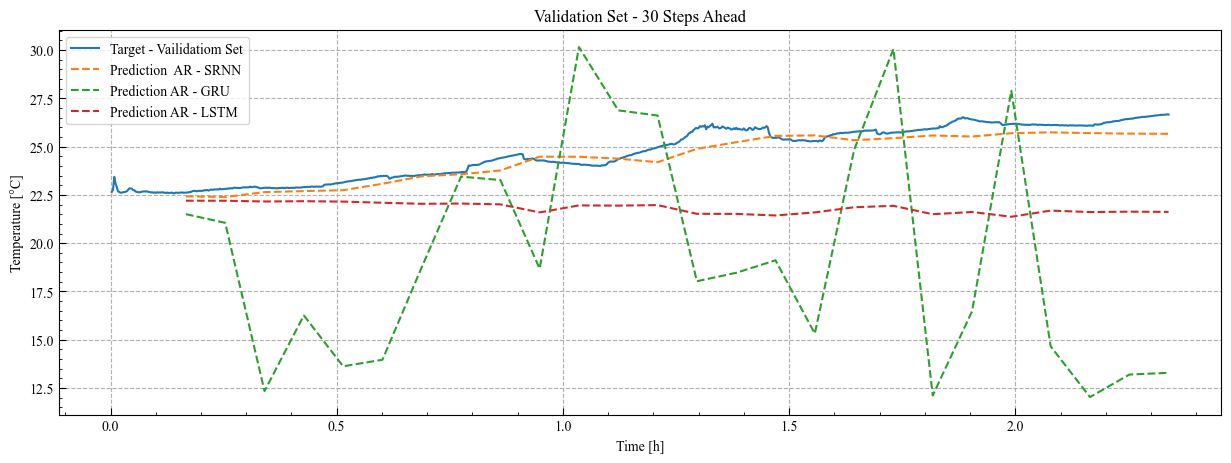

In [100]:
plt.figure(figsize=(15,5))

plt.plot(np.linspace(1,len(y_valid_sequence),len(y_valid_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_valid_sequence), '-', label = 'Target - Vailidatiom Set')

plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_valid_sequence),int(np.ceil((len(y_valid_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_valid_SRNN).reshape(np.array(AutoG_valid_SRNN).shape[0], 1)), '--', label = 'Prediction  AR - SRNN')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_valid_sequence),int(np.ceil((len(y_valid_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_valid_GRU).reshape(np.array(AutoG_valid_GRU).shape[0], 1)), '--', label = 'Prediction AR - GRU')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_valid_sequence),int(np.ceil((len(y_valid_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_valid_LSTM).reshape(np.array(AutoG_valid_LSTM).shape[0], 1)), '--', label = 'Prediction AR - LSTM')

plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Validation Set - ' + str(N_steps_ahead) + ' Steps Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Valid_Last_AR.pdf', dpi = 300, bbox_inches='tight')

41/41 [==============================] - 0s 3ms/step


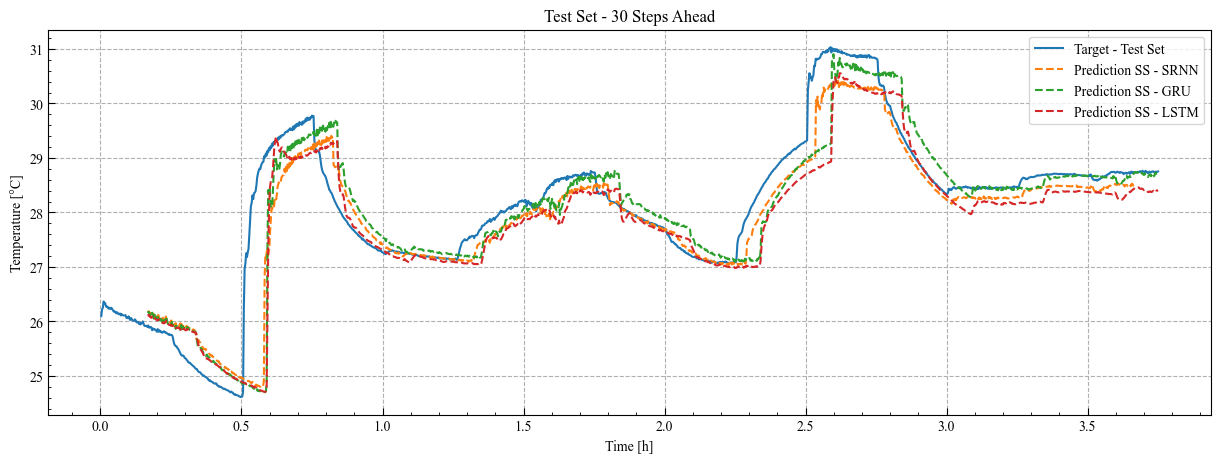

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,len(y_test_sequence),len(y_test_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_test_sequence), '-', label = 'Target - Test Set')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence) - N_steps_ahead,len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_SRNN.predict([X_test_endogenous, X_test_exogenous]).T[-1].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction SS - SRNN')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence),len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_GRU.predict([X_test_endogenous, X_test_exogenous]).T[-1].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction SS - GRU')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence),len(y_test_sequence)-N_steps_ahead-N_steps_back)/60/(60/roll),
         scaller_endogenous.inverse_transform(model_LSTM.predict([X_test_endogenous, X_test_exogenous]).T[-1].reshape(len(y_test_sequence) - N_steps_ahead - N_steps_back, 1)), '--', label = 'Prediction SS - LSTM')

plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Test Set - ' + str(N_steps_ahead) +' Steps Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Test_Last_SS.pdf', dpi = 300, bbox_inches='tight')

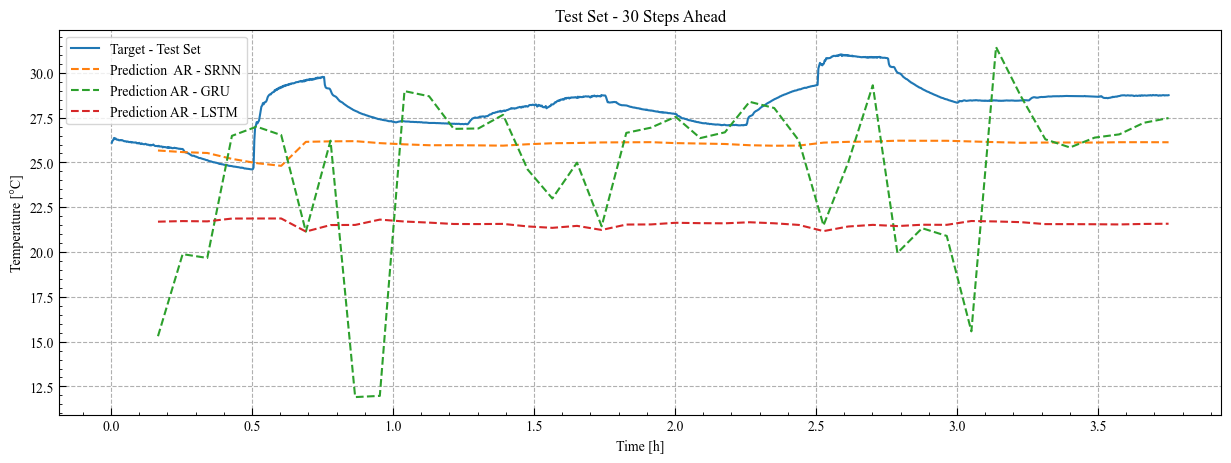

In [101]:
plt.figure(figsize=(15,5))

plt.plot(np.linspace(1,len(y_test_sequence),len(y_test_sequence))/60/(60/roll),scaller_endogenous.inverse_transform(y_test_sequence), '-', label = 'Target - Test Set')

plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence),int(np.ceil((len(y_test_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_test_SRNN).reshape(np.array(AutoG_test_SRNN).shape[0], 1)), '--', label = 'Prediction  AR - SRNN')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence),int(np.ceil((len(y_test_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_test_GRU).reshape(np.array(AutoG_test_GRU).shape[0], 1)), '--', label = 'Prediction AR - GRU')
plt.plot(np.linspace(N_steps_back + N_steps_ahead,len(y_test_sequence),int(np.ceil((len(y_test_sequence)-2*N_steps_ahead-N_steps_back)/30)))/60/(60/roll),
         scaller_endogenous.inverse_transform(np.array(AutoG_test_LSTM).reshape(np.array(AutoG_test_LSTM).shape[0], 1)), '--', label = 'Prediction AR - LSTM')

plt.legend()
plt.grid(ls = '--')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.title('Test Set - ' + str(N_steps_ahead) + ' Steps Ahead')
plt.ylabel('Temperature [°C]')
plt.xlabel('Time [h]')
plt.savefig('Figures/Comp_Test_Last_AR.pdf', dpi = 300, bbox_inches='tight')

#### Coefficient of Determination

In [ ]:
def R2(y, x_endo, x_exo, model,steps):
    R2_sc = r2_score(
        scaller_endogenous.inverse_transform(y[N_steps_back + steps -1 : - N_steps_ahead + steps - 1].reshape(-1, 1)),
        scaller_endogenous.inverse_transform(model.predict([x_endo, x_exo], verbose = 0).T[steps -1].reshape(y.shape[0] - N_steps_ahead - N_steps_back, 1))
    )
    
    return R2_sc

In [ ]:
R2_SRNN_1 = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_SRNN, 1)
R2_GRU_1  = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_GRU, 1)
R2_LSTM_1 = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_LSTM, 1)

In [ ]:
print('R2 SRNN 1 Step Ahead: ', R2_SRNN_1)
print('R2 GRU 1 Step Ahead: ', R2_GRU_1)
print('R2 LSTM 1 Step Ahead: ', R2_LSTM_1)

R2 SRNN 1 Step Ahead:  0.9865544394914526
R2 GRU 1 Step Ahead:  0.9948104687608282
R2 LSTM 1 Step Ahead:  0.9842876679262835


In [ ]:
R2_SRNN_SS_30 = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_SRNN, 30)
R2_GRU_SS_30  = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_GRU, 30)
R2_LSTM_SS_30 = R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_LSTM, 30)

In [ ]:
print('R2 SRNN 30 Step Ahead: ', R2_SRNN_SS_30)
print('R2 GRU 30 Step Ahead: ', R2_GRU_SS_30)
print('R2 LSTM 30 Step Ahead: ', R2_LSTM_SS_30)

R2 SRNN 30 Step Ahead:  0.6855994803788183
R2 GRU 30 Step Ahead:  0.7283976728783956
R2 LSTM 30 Step Ahead:  0.7009631056464696


In [ ]:
R2_SRNN_seq = []
R2_GRU_seq = []
R2_LSTM_seq = []

for i in range(N_steps_ahead):
    R2_SRNN_seq.append(R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_SRNN, i+1))
    R2_GRU_seq.append(R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_GRU, i+1))
    R2_LSTM_seq.append(R2(y_test_sequence, X_test_endogenous, X_test_exogenous, model_LSTM, i+1))

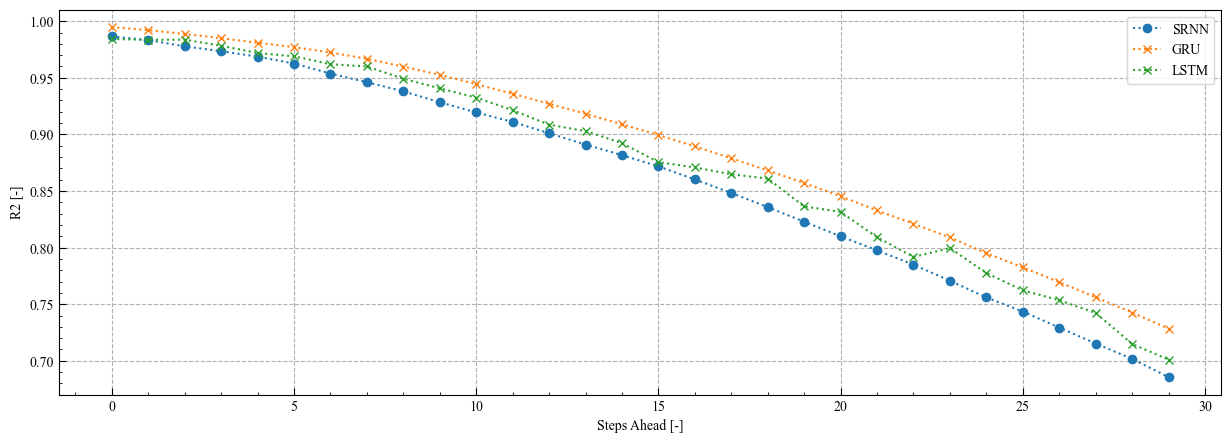

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(R2_SRNN_seq, ':o', label = 'SRNN')
plt.plot(R2_GRU_seq, ':x', label = 'GRU')
plt.plot(R2_LSTM_seq, ':x', label = 'LSTM')
plt.legend()
plt.grid(ls = '--')
plt.xlabel('Steps Ahead [-]')
plt.ylabel('R2 [-]')
plt.tick_params(direction = 'in',length = 5,which = 'major')
plt.tick_params(direction = 'in',length = 2,which = 'minor')
plt.minorticks_on()
plt.savefig('Figures/R2.pdf', dpi = 300, bbox_inches='tight')

In [ ]:
R2 = [
[r2_train_SRNN, r2_valid_SRNN, r2_test_SRNN], 
[r2_train_GRU, r2_valid_GRU, r2_test_GRU],
[r2_train_LSTM, r2_valid_LSTM, r2_test_LSTM]
]

In [ ]:
pd.DataFrame(R2, columns = ['Train', 'Validation', 'Test'], index = ['SRNN', 'GRU', 'LSTM']).to_excel('R2.xlsx')